10k Songs & Adding Audio | Spotify Connection

In [1]:
!pip install spotipy

In [2]:
import pandas as pd
from pandas import json_normalize

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from random import randint
from time import sleep

In [3]:
pd.set_option("display.max_columns", 0)

In [4]:
secrets_file = open("secrets1.txt","r")

Spotify Connection

In [5]:
string = secrets_file.read()

In [6]:
string

'clientid:ad6becd2bbb14a27ab52a381a9dd9b69\nclientsecret:d7fcf66c4ea241aa958d81cc53c41063'

In [7]:
secrets_dict={}
for line in string.split('\n'):
    if len(line) > 0:
        #print(line.split(':'))
        secrets_dict[line.split(':')[0]]=line.split(':')[1].strip()

In [8]:
secrets_dict

{'clientid': 'ad6becd2bbb14a27ab52a381a9dd9b69',
 'clientsecret': 'd7fcf66c4ea241aa958d81cc53c41063'}

In [9]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

#Initialize SpotiPy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=secrets_dict['clientid'],
                                                           client_secret=secrets_dict['clientsecret']))

Top-1000-Playlist

In [10]:
def get_playlist_tracks(playlist_id):
    results = sp.user_playlist_tracks("spotify",playlist_id)
    tracks = results['items']
    while results['next']!=None:
        results = sp.next(results)
        tracks = tracks + results['items']
        sleep(randint(1,3000)/1000) # respectful nap
    return tracks

In [11]:
all_tracks = get_playlist_tracks("2LOxEzC4KmoWJ9NhW0kz5M")
# https://open.spotify.com/playlist/2LOxEzC4KmoWJ9NhW0kz5M
# all_tracks = sp.user_playlist_tracks("spotify", "2LOxEzC4KmoWJ9NhW0kz5M")

In [12]:
len(all_tracks)

992

In [13]:
tracks = json_normalize(all_tracks)

In [14]:
artists_df = pd.DataFrame(columns=['href', 'id', 'name', 'type', 'uri', 'external_urls.spotify','song_id', 'song_name', 'popularity' ])
for i in tracks.index:
    artists_for_song = json_normalize(tracks.iloc[i]['track.artists'])
    artists_for_song['song_id']    = tracks.iloc[i]['track.id']         # we want to keep song_id, it is the sae for all artists
    artists_for_song['song_name']  = tracks.iloc[i]['track.name']       # we want to keep song_name, it is the sae for all artists
    artists_for_song['popularity'] = tracks.iloc[i]['track.popularity'] # same for popularity   
    artists_df = pd.concat([artists_df, artists_for_song], axis=0)

In [15]:
artists_df.head()

,href,id,name,type,uri,external_urls.spotify,song_id,song_name,popularity
0,https://api.spotify.com/v1/artists/1dfeR4HaWDb...,1dfeR4HaWDbWqFHLkxsg1d,Queen,artist,spotify:artist:1dfeR4HaWDbWqFHLkxsg1d,https://open.spotify.com/artist/1dfeR4HaWDbWqF...,1AhDOtG9vPSOmsWgNW0BEY,Bohemian Rhapsody - Remastered 2011,0
0,https://api.spotify.com/v1/artists/3qm84nBOXUE...,3qm84nBOXUEQ2vnTfUTTFC,Guns N' Roses,artist,spotify:artist:3qm84nBOXUEQ2vnTfUTTFC,https://open.spotify.com/artist/3qm84nBOXUEQ2v...,7o2CTH4ctstm8TNelqjb51,Sweet Child O' Mine,9
0,https://api.spotify.com/v1/artists/6olE6TJLqED...,6olE6TJLqED3rqDCT0FyPh,Nirvana,artist,spotify:artist:6olE6TJLqED3rqDCT0FyPh,https://open.spotify.com/artist/6olE6TJLqED3rq...,1f3yAtsJtY87CTmM8RLnxf,Smells Like Teen Spirit,2
0,https://api.spotify.com/v1/artists/4x1nvY2FN8j...,4x1nvY2FN8jxqAFA0DA02H,John Lennon,artist,spotify:artist:4x1nvY2FN8jxqAFA0DA02H,https://open.spotify.com/artist/4x1nvY2FN8jxqA...,7pKfPomDEeI4TPT6EOYjn9,Imagine - Remastered 2010,76
0,https://api.spotify.com/v1/artists/1QxaPWG1POM...,1QxaPWG1POM8Ul6WwsHq4y,John Farnham,artist,spotify:artist:1QxaPWG1POM8Ul6WwsHq4y,https://open.spotify.com/artist/1QxaPWG1POM8Ul...,5NwkWwfRJaT55hEPtCmJHx,You're the Voice,60


In [16]:
df_final = artists_df[['song_name', 'name', 'song_id', 'popularity']].reset_index(drop=True)
df_final

,song_name,name,song_id,popularity
0,Bohemian Rhapsody - Remastered 2011,Queen,1AhDOtG9vPSOmsWgNW0BEY,0
1,Sweet Child O' Mine,Guns N' Roses,7o2CTH4ctstm8TNelqjb51,9
2,Smells Like Teen Spirit,Nirvana,1f3yAtsJtY87CTmM8RLnxf,2
3,Imagine - Remastered 2010,John Lennon,7pKfPomDEeI4TPT6EOYjn9,76
4,You're the Voice,John Farnham,5NwkWwfRJaT55hEPtCmJHx,60
...,...,...,...,...
1063,Running on Empty,Jackson Browne,4MZEZz8MqVgvIMXU6AVP22,0
1064,Every Little Thing She Does Is Magic - Remaste...,The Police,5pDmunv6G71w7NSjOPXbYw,0
1065,Doo Wop (That Thing),Ms. Lauryn Hill,2Uu8IiLkLY0UXhCHka4Dlr,0
1066,The Boys Are Back In Town,Thin Lizzy,43DeSV93pJPT4lCZaWZ6b1,74


In [17]:
df_final.isna().sum()
#drop the rows with null values in song_id due to not to extract song features for them

song_name     0
name          0
song_id       0
popularity    0
dtype: int64

In [18]:
df_final2=df_final.dropna()
df_final2

,song_name,name,song_id,popularity
0,Bohemian Rhapsody - Remastered 2011,Queen,1AhDOtG9vPSOmsWgNW0BEY,0
1,Sweet Child O' Mine,Guns N' Roses,7o2CTH4ctstm8TNelqjb51,9
2,Smells Like Teen Spirit,Nirvana,1f3yAtsJtY87CTmM8RLnxf,2
3,Imagine - Remastered 2010,John Lennon,7pKfPomDEeI4TPT6EOYjn9,76
4,You're the Voice,John Farnham,5NwkWwfRJaT55hEPtCmJHx,60
...,...,...,...,...
1063,Running on Empty,Jackson Browne,4MZEZz8MqVgvIMXU6AVP22,0
1064,Every Little Thing She Does Is Magic - Remaste...,The Police,5pDmunv6G71w7NSjOPXbYw,0
1065,Doo Wop (That Thing),Ms. Lauryn Hill,2Uu8IiLkLY0UXhCHka4Dlr,0
1066,The Boys Are Back In Town,Thin Lizzy,43DeSV93pJPT4lCZaWZ6b1,74


Audio Features 

In [19]:
chunks = [(i, i+100) for i in range(0, len(df_final), 100)]
chunks  #produces a list of tuples
audio_features_list = []
for chunk in chunks:
    id_list100 = df_final['song_id'][chunk[0]:chunk[1]]   #chunk[0]= first number of the tuple, chunk[1]= second number
    audio_features_list = audio_features_list + sp.audio_features(id_list100)
    sleep(randint(1,3000)/1000)

In [20]:
audio_features_df = json_normalize(audio_features_list)
audio_features_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.414,0.404,0,-9.928,0,0.0499,0.271000,0.000000,0.3000,0.224,71.105,audio_features,1AhDOtG9vPSOmsWgNW0BEY,spotify:track:1AhDOtG9vPSOmsWgNW0BEY,https://api.spotify.com/v1/tracks/1AhDOtG9vPSO...,https://api.spotify.com/v1/audio-analysis/1AhD...,354320,4
1,0.454,0.910,6,-7.766,1,0.0448,0.086600,0.099600,0.1160,0.629,125.116,audio_features,7o2CTH4ctstm8TNelqjb51,spotify:track:7o2CTH4ctstm8TNelqjb51,https://api.spotify.com/v1/tracks/7o2CTH4ctstm...,https://api.spotify.com/v1/audio-analysis/7o2C...,354520,4
2,0.502,0.912,1,-4.556,1,0.0564,0.000025,0.000173,0.1060,0.720,116.761,audio_features,1f3yAtsJtY87CTmM8RLnxf,spotify:track:1f3yAtsJtY87CTmM8RLnxf,https://api.spotify.com/v1/tracks/1f3yAtsJtY87...,https://api.spotify.com/v1/audio-analysis/1f3y...,301920,4
3,0.547,0.257,0,-12.358,1,0.0252,0.907000,0.183000,0.0935,0.169,75.752,audio_features,7pKfPomDEeI4TPT6EOYjn9,spotify:track:7pKfPomDEeI4TPT6EOYjn9,https://api.spotify.com/v1/tracks/7pKfPomDEeI4...,https://api.spotify.com/v1/audio-analysis/7pKf...,187867,4
4,0.369,0.762,10,-8.993,1,0.0464,0.220000,0.000028,0.5790,0.644,84.957,audio_features,5NwkWwfRJaT55hEPtCmJHx,spotify:track:5NwkWwfRJaT55hEPtCmJHx,https://api.spotify.com/v1/tracks/5NwkWwfRJaT5...,https://api.spotify.com/v1/audio-analysis/5Nwk...,302107,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,0.531,0.948,9,-5.438,1,0.0568,0.006000,0.011700,0.6940,0.498,136.891,audio_features,4MZEZz8MqVgvIMXU6AVP22,spotify:track:4MZEZz8MqVgvIMXU6AVP22,https://api.spotify.com/v1/tracks/4MZEZz8MqVgv...,https://api.spotify.com/v1/audio-analysis/4MZE...,298093,4
1064,0.535,0.745,2,-10.123,1,0.0335,0.127000,0.079200,0.1790,0.376,163.913,audio_features,5pDmunv6G71w7NSjOPXbYw,spotify:track:5pDmunv6G71w7NSjOPXbYw,https://api.spotify.com/v1/tracks/5pDmunv6G71w...,https://api.spotify.com/v1/audio-analysis/5pDm...,260573,4
1065,0.535,0.505,2,-8.926,0,0.2450,0.039300,0.000000,0.0923,0.495,99.935,audio_features,2Uu8IiLkLY0UXhCHka4Dlr,spotify:track:2Uu8IiLkLY0UXhCHka4Dlr,https://api.spotify.com/v1/tracks/2Uu8IiLkLY0U...,https://api.spotify.com/v1/audio-analysis/2Uu8...,320267,4
1066,0.445,0.706,8,-9.803,1,0.0461,0.234000,0.000252,0.2050,0.768,80.823,audio_features,43DeSV93pJPT4lCZaWZ6b1,spotify:track:43DeSV93pJPT4lCZaWZ6b1,https://api.spotify.com/v1/tracks/43DeSV93pJPT...,https://api.spotify.com/v1/audio-analysis/43De...,266720,4


In [21]:
audio_features_df.drop_duplicates(inplace=True) # duplicates because some songs have more artists
audio_features_df.shape

(992, 18)

Concatenating the songs with their audio features and exporting the df in a csv file

In [22]:
df_w_audio_ft = pd.merge(left=df_final, right=audio_features_df, how='inner', left_on='song_id',right_on='id')
df_w_audio_ft

,song_name,name,song_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Bohemian Rhapsody - Remastered 2011,Queen,1AhDOtG9vPSOmsWgNW0BEY,0,0.414,0.404,0,-9.928,0,0.0499,0.271000,0.000000,0.3000,0.224,71.105,audio_features,1AhDOtG9vPSOmsWgNW0BEY,spotify:track:1AhDOtG9vPSOmsWgNW0BEY,https://api.spotify.com/v1/tracks/1AhDOtG9vPSO...,https://api.spotify.com/v1/audio-analysis/1AhD...,354320,4
1,Sweet Child O' Mine,Guns N' Roses,7o2CTH4ctstm8TNelqjb51,9,0.454,0.910,6,-7.766,1,0.0448,0.086600,0.099600,0.1160,0.629,125.116,audio_features,7o2CTH4ctstm8TNelqjb51,spotify:track:7o2CTH4ctstm8TNelqjb51,https://api.spotify.com/v1/tracks/7o2CTH4ctstm...,https://api.spotify.com/v1/audio-analysis/7o2C...,354520,4
2,Smells Like Teen Spirit,Nirvana,1f3yAtsJtY87CTmM8RLnxf,2,0.502,0.912,1,-4.556,1,0.0564,0.000025,0.000173,0.1060,0.720,116.761,audio_features,1f3yAtsJtY87CTmM8RLnxf,spotify:track:1f3yAtsJtY87CTmM8RLnxf,https://api.spotify.com/v1/tracks/1f3yAtsJtY87...,https://api.spotify.com/v1/audio-analysis/1f3y...,301920,4
3,Imagine - Remastered 2010,John Lennon,7pKfPomDEeI4TPT6EOYjn9,76,0.547,0.257,0,-12.358,1,0.0252,0.907000,0.183000,0.0935,0.169,75.752,audio_features,7pKfPomDEeI4TPT6EOYjn9,spotify:track:7pKfPomDEeI4TPT6EOYjn9,https://api.spotify.com/v1/tracks/7pKfPomDEeI4...,https://api.spotify.com/v1/audio-analysis/7pKf...,187867,4
4,You're the Voice,John Farnham,5NwkWwfRJaT55hEPtCmJHx,60,0.369,0.762,10,-8.993,1,0.0464,0.220000,0.000028,0.5790,0.644,84.957,audio_features,5NwkWwfRJaT55hEPtCmJHx,spotify:track:5NwkWwfRJaT55hEPtCmJHx,https://api.spotify.com/v1/tracks/5NwkWwfRJaT5...,https://api.spotify.com/v1/audio-analysis/5Nwk...,302107,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,Running on Empty,Jackson Browne,4MZEZz8MqVgvIMXU6AVP22,0,0.531,0.948,9,-5.438,1,0.0568,0.006000,0.011700,0.6940,0.498,136.891,audio_features,4MZEZz8MqVgvIMXU6AVP22,spotify:track:4MZEZz8MqVgvIMXU6AVP22,https://api.spotify.com/v1/tracks/4MZEZz8MqVgv...,https://api.spotify.com/v1/audio-analysis/4MZE...,298093,4
1064,Every Little Thing She Does Is Magic - Remaste...,The Police,5pDmunv6G71w7NSjOPXbYw,0,0.535,0.745,2,-10.123,1,0.0335,0.127000,0.079200,0.1790,0.376,163.913,audio_features,5pDmunv6G71w7NSjOPXbYw,spotify:track:5pDmunv6G71w7NSjOPXbYw,https://api.spotify.com/v1/tracks/5pDmunv6G71w...,https://api.spotify.com/v1/audio-analysis/5pDm...,260573,4
1065,Doo Wop (That Thing),Ms. Lauryn Hill,2Uu8IiLkLY0UXhCHka4Dlr,0,0.535,0.505,2,-8.926,0,0.2450,0.039300,0.000000,0.0923,0.495,99.935,audio_features,2Uu8IiLkLY0UXhCHka4Dlr,spotify:track:2Uu8IiLkLY0UXhCHka4Dlr,https://api.spotify.com/v1/tracks/2Uu8IiLkLY0U...,https://api.spotify.com/v1/audio-analysis/2Uu8...,320267,4
1066,The Boys Are Back In Town,Thin Lizzy,43DeSV93pJPT4lCZaWZ6b1,74,0.445,0.706,8,-9.803,1,0.0461,0.234000,0.000252,0.2050,0.768,80.823,audio_features,43DeSV93pJPT4lCZaWZ6b1,spotify:track:43DeSV93pJPT4lCZaWZ6b1,https://api.spotify.com/v1/tracks/43DeSV93pJPT...,https://api.spotify.com/v1/audio-analysis/43De...,266720,4


In [23]:
df_w_audio_ft.to_csv('top_992_songs.csv', index=False)

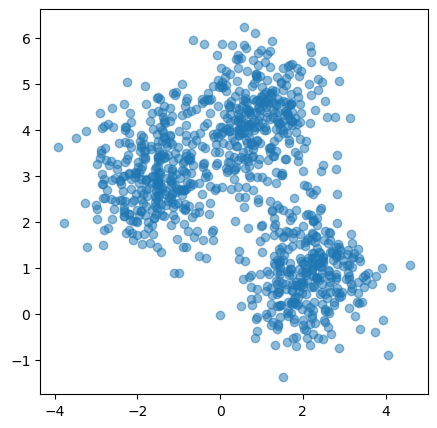

In [24]:
# K-means
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D


n_samples = 992
X, _ = datasets.make_blobs(n_samples=n_samples, centers=3, cluster_std=0.8, n_features=2, random_state=0)

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5,)
plt.show()

In [25]:
X

array([[ 2.87961814, -0.74019523],
       [ 1.5312886 ,  4.17612858],
       [ 1.73402149,  0.52288282],
       ...,
       [ 2.02665306,  2.80225994],
       [-1.94984054,  2.83147919],
       [-0.7519085 ,  2.33359658]])

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


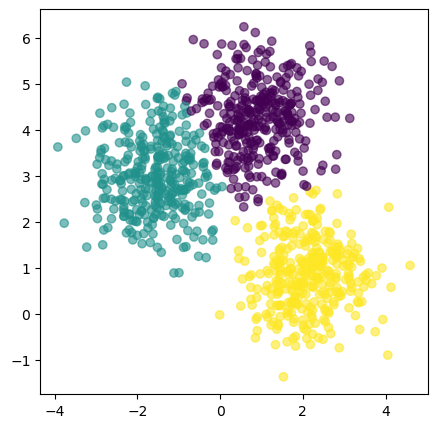

CPU times: user 666 ms, sys: 221 ms, total: 887 ms
Wall time: 338 ms


In [26]:
%%time
kmeans = cluster.KMeans(n_clusters=3)
kmeans.fit(X)
pred = kmeans.predict(X)

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=pred,alpha=0.6)
plt.show()

In [27]:
pred[0:20]

array([2, 0, 2, 0, 0, 1, 0, 2, 1, 1, 0, 1, 1, 2, 2, 2, 0, 0, 0, 1],
      dtype=int32)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


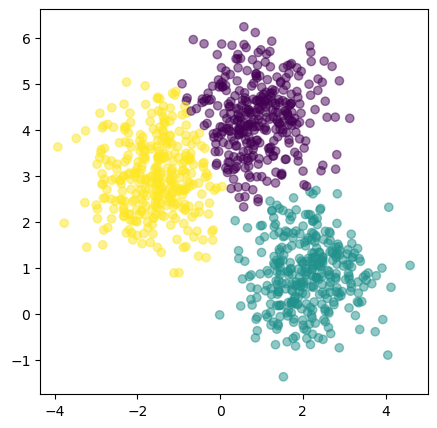

In [28]:
kmeans = cluster.KMeans(n_clusters=3)
kmeans.fit(X)
pred = kmeans.predict(X)

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=pred, alpha=0.5)
plt.show()

In [41]:
from sklearn.preprocessing import StandardScaler
X_prep = StandardScaler().fit_transform(X)

# Now, all features will have the same weight.
pd.DataFrame(X_prep,columns=X.columns).head()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [42]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=134)
kmeans.fit(X_prep)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=134)

In [43]:
# Predicting / assigning the clusters:
clusters = kmeans.predict(X_prep)

# Check the size of the clusters
pd.Series(clusters).value_counts().sort_index()

0    330
1    331
2    331
Name: count, dtype: int64

In [44]:
clusters

array([1, 2, 1, 2, 2, 0, 2, 1, 0, 0, 2, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0, 2,
       2, 2, 1, 1, 2, 2, 0, 2, 1, 2, 1, 1, 1, 2, 0, 0, 1, 2, 2, 1, 2, 1,
       1, 0, 2, 1, 2, 1, 0, 0, 1, 0, 2, 2, 2, 1, 0, 1, 0, 2, 2, 2, 0, 2,
       0, 2, 0, 2, 0, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 0, 2, 1, 2, 2, 0, 2,
       2, 2, 1, 1, 2, 2, 2, 1, 1, 0, 0, 2, 2, 0, 1, 2, 0, 2, 1, 2, 2, 2,
       2, 2, 1, 2, 1, 0, 1, 2, 1, 2, 2, 0, 1, 2, 0, 2, 2, 2, 0, 0, 2, 0,
       2, 2, 0, 2, 0, 0, 1, 2, 0, 0, 0, 2, 2, 1, 2, 0, 2, 0, 2, 0, 2, 1,
       1, 2, 0, 1, 2, 0, 2, 1, 2, 0, 1, 2, 0, 2, 2, 0, 0, 1, 0, 1, 0, 0,
       2, 0, 1, 1, 2, 1, 1, 0, 2, 0, 0, 2, 0, 1, 2, 0, 2, 2, 0, 0, 1, 0,
       1, 2, 0, 2, 0, 1, 0, 0, 1, 2, 1, 0, 1, 1, 0, 1, 0, 0, 0, 2, 1, 0,
       2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 1, 0, 0, 2, 0, 0, 2, 2, 2, 2, 1,
       0, 1, 1, 1, 0, 2, 1, 2, 2, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 2, 0, 1,
       1, 2, 0, 1, 1, 1, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 1, 1, 1, 0, 0, 2,
       1, 1, 0, 2, 0, 0, 2, 1, 1, 0, 1, 2, 1, 2, 1,

In [45]:
plt.figure(figsize=(5, 5))
plt.scatter(X_prep[:, 0], X_prep[:, 3], c=clusters,alpha=0.5)
plt.show()

IndexError: index 3 is out of bounds for axis 1 with size 2

<Figure size 500x500 with 0 Axes>

In [46]:
kmeans.inertia_

419.520356132828

In [47]:
%%time
kmeans = KMeans(n_clusters=8,
                init="random",
                n_init= 1,  # try with 1, 4, 8, 20, 30, 100...
                max_iter=10,
                tol=0,
                random_state=123)
kmeans.fit(X_prep)
print(kmeans.inertia_)

203.2149147672664
CPU times: user 12.1 ms, sys: 5.09 ms, total: 17.2 ms
Wall time: 11 ms


Choosing K

In [48]:
import pandas as pd
#from sklearn import datasets

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

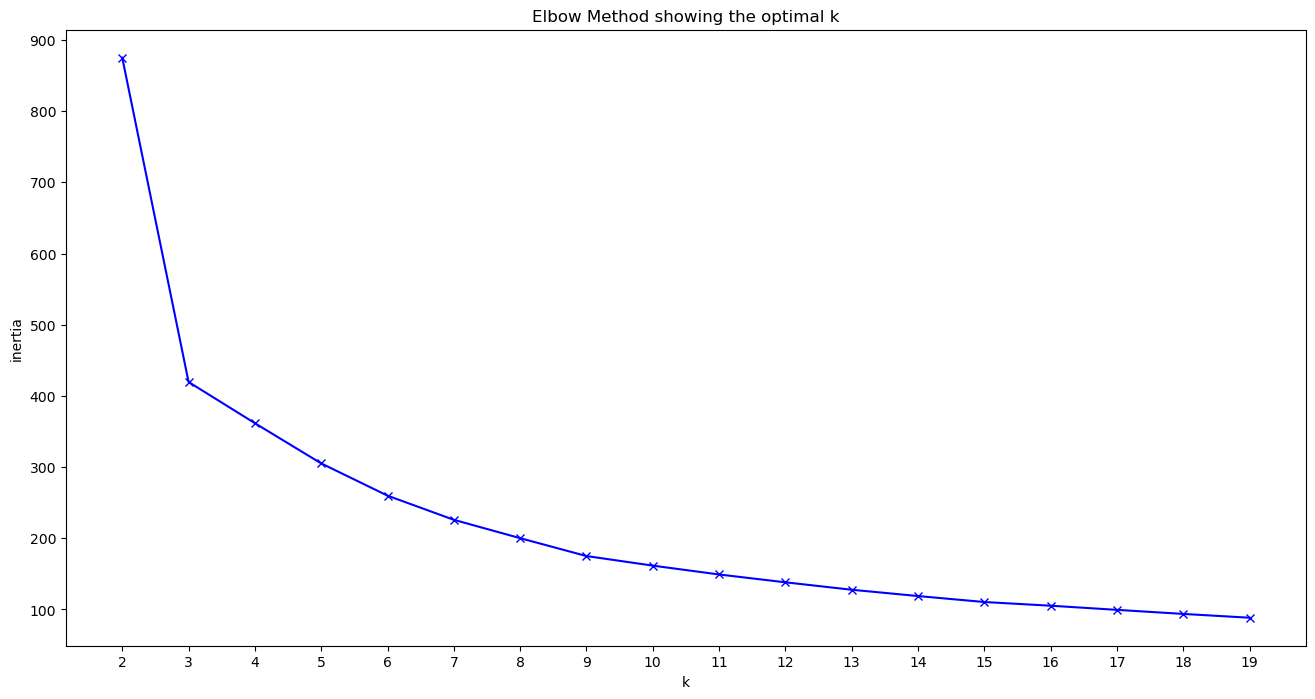

In [49]:
import numpy as np
K = range(2, 20)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=123)
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

Text(0.5, 1.0, 'Slhouette score showing the optimal k')

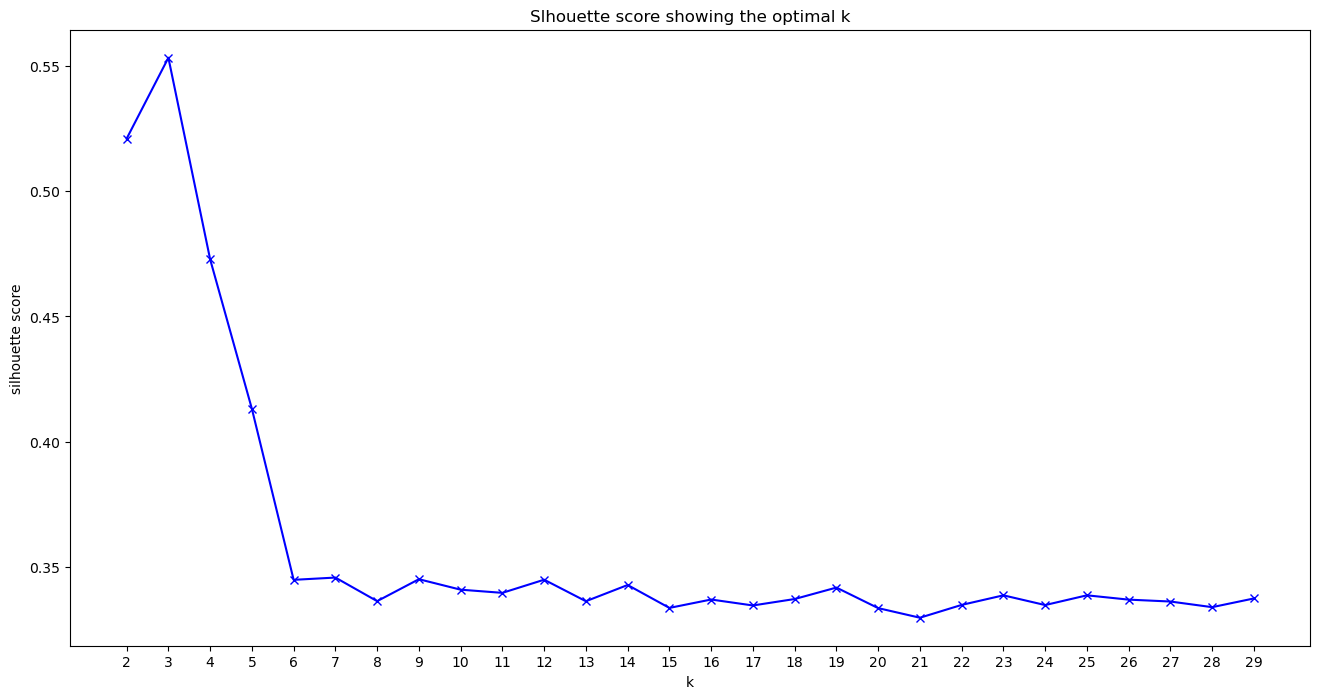

In [50]:
from sklearn.metrics import silhouette_score
K = range(2, 30)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=323)
    kmeans.fit(X_prep)
    silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Slhouette score showing the optimal k')

Agglomerative clustering

In [51]:
from sklearn import cluster

In [52]:
X

array([[ 2.87961814, -0.74019523],
       [ 1.5312886 ,  4.17612858],
       [ 1.73402149,  0.52288282],
       ...,
       [ 2.02665306,  2.80225994],
       [-1.94984054,  2.83147919],
       [-0.7519085 ,  2.33359658]])

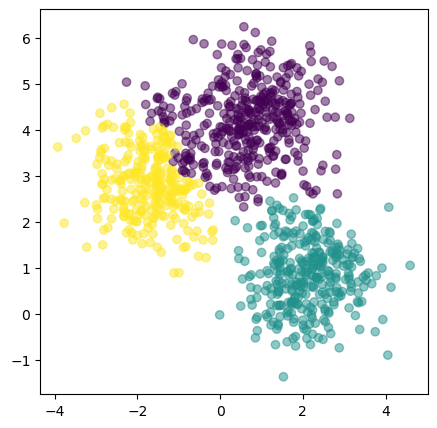

In [53]:
# ward linkage tends to produce relatively equally sized clusters
agglomerative = cluster.AgglomerativeClustering(n_clusters=3,linkage='ward')
pred = agglomerative.fit_predict(X)

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=pred,alpha=0.5)
#plt.scatter(X['alcohol'], X['malic_acid'], c=pred,alpha=0.5)
plt.show()

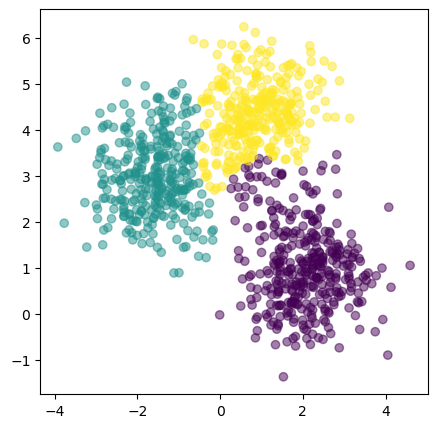

In [54]:
# complete linkage penalizes heavily outliers
agglomerative = cluster.AgglomerativeClustering(n_clusters=3,linkage='complete')
pred = agglomerative.fit_predict(X)

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=pred,alpha=0.5)
plt.show()

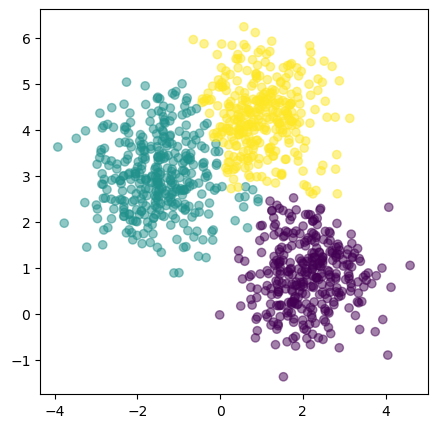

In [55]:
c

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


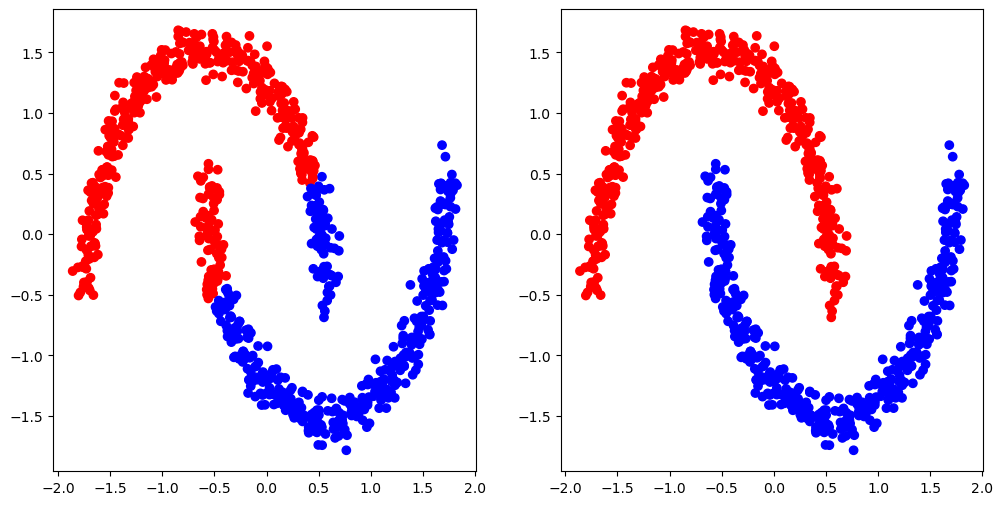

In [57]:
#from matplotlib.lines import Line2D
#from sklearn.metrics import silhouette_score

# different algorithms are good for different applications - kmeans and single agglomerative have so far shown very different results

n_samples = 900
X, _ = datasets.make_moons(n_samples=n_samples, noise=.05)
X = StandardScaler().fit_transform(X)

kmeans = cluster.KMeans(n_clusters=2)
kmeans.fit(X)
km_clusters = kmeans.predict(X)


single = cluster.AgglomerativeClustering(n_clusters=2, linkage='single')
ag_clusters = single.fit_predict(X)


options, charts = plt.subplots(1, 2, figsize=(12, 6))
colors = np.array(['blue', 'red'])
charts[0].scatter(X[:, 0], X[:, 1], color=colors[km_clusters])
charts[1].scatter(X[:, 0], X[:, 1], color=colors[ag_clusters])
plt.show()

In [66]:
from sklearn.cluster import AgglomerativeClustering


# Perform agglomerative clustering
agglomerative = AgglomerativeClustering(n_clusters=3, linkage='average')
pred = agglomerative.fit_predict(X)

# Convert the numpy array into a pandas DataFrame
data_df = pd.DataFrame(X, columns=['song_name', 'name', 'song_id', 'popularity'])

# Add a column for the cluster labels
data_df['Cluster'] = pred

# Create separate data frames for each cluster
cluster_data_frames = [data_df[data_df['Cluster'] == i].drop('Cluster', axis=1) for i in range(agglomerative.n_clusters)]

# Display the first few rows of each cluster's data frame
for i, cluster_df in enumerate(cluster_data_frames):
    print(f"Cluster{i} data frame:")
    print(cluster_df.head())
    
#song_name	name	song_id	popularity

Cluster0 data frame:
     song_name      name   song_id  popularity
101   2.488442  1.695970  0.141807    1.833435
194   1.511639  1.706468  0.701783    0.073285
249   0.583368  0.926605  1.800463   -1.195104
272   1.951761  1.239941  0.938585   -1.019251
291   1.855246  1.415656 -0.302746    0.989679
Cluster1 data frame:
     song_name      name   song_id  popularity
22    1.660608 -1.416603 -2.802203   -1.188424
29    0.542611  0.715939 -2.994613    0.880938
104   0.604137 -1.629584 -2.121176   -1.838847
172   0.708860  0.422819 -3.116857    0.644452
196  -0.063661 -1.579931 -2.832012   -1.083427
Cluster2 data frame:
   song_name      name   song_id  popularity
0   1.145262  0.346494  0.774161   -0.774459
1   0.104907  0.133913 -0.612626   -0.822828
2  -1.490265  1.496140 -0.972403    1.346221
3  -0.467493 -0.862493  0.622519   -0.631192
4   0.568459 -0.332812  0.480424   -0.968186


In [ ]:
# how can I bring real song_name from the song_id 